In [22]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
import scipy.stats as stats
from scipy.stats import linregress
import pprint
import json
from time import sleep
from datetime import date
import zipfile
import os

# Incorporated citipy to determine city based on latitude and longitude
# pip install citipy
from citipy import citipy

# Output File location
output_folder = "output_data"

In [3]:
# Open the zip file:
csvpath = os.path.join("..", "source_data", "detail_listings.zip")
zf = zipfile.ZipFile(csvpath);

# zf = zipfile.ZipFile('../source_data/detail_listings.zip') 
df = pd.read_csv(zf.open('detail_listings.csv'), low_memory=False)

rows_in_df = len(df)
print(f'Data set has {rows_in_df} rows')

# Drop unneeded columns:
df = df.drop(columns = [
    "listing_url", 
    "thumbnail_url", 
    "picture_url", 
    "medium_url", 
    "xl_picture_url", 
    "host_url", 
    "host_thumbnail_url", 
    "host_picture_url", 
    "scrape_id",
    "host_listings_count", # There is a host_total_listings_count that is a dupe
    "host_acceptance_rate", # NaN
    "calendar_last_scraped",
    "bed_type",
    "last_scraped",
    "calendar_updated",
    "has_availability",
    "availability_30", 
    "availability_60", 
    "availability_90", 
    "availability_365", 
    "license"
])

df.head(1)

Data set has 23745 rows


,id,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,...,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,5065,MAUKA BB,"Perfect for your vacation, Staycation or just ...",Mauka B & B is 400 square feet studio with a p...,"Perfect for your vacation, Staycation or just ...",none,Neighbors here are friendly but are not really...,Located near by is Kalopa State Park with 100 ...,There is a bus stop located in Honoka'a town ...,A BBQ grill is available,...,f,f,moderate,f,f,2,2,0,0,0.45


In [4]:
# Group the columns 
        
print('')
print('----------------------')
print('Property-specific columns:')
print('----------------------')
# These are wildcard search terms:
cols = ["experiences_offered", "street", "city", "state", "zipcode", "market", "country", "property"
    , "location", "accomodate", "room", "guest", "is_business_travel_ready", "instant_bookable", "cancel"]
for col in df.columns: 
    if col in cols:
        print(col) 
        
print('')
print('----------------------')
print('All columns:')
print('----------------------')
for col in df.columns: 
    print(col) 


----------------------
Property-specific columns:
----------------------
experiences_offered
street
city
state
zipcode
market
country
instant_bookable
is_business_travel_ready

----------------------
All columns:
----------------------
id
name
summary
space
description
experiences_offered
neighborhood_overview
notes
transit
access
interaction
house_rules
host_id
host_name
host_since
host_location
host_about
host_response_time
host_response_rate
host_is_superhost
host_neighbourhood
host_total_listings_count
host_verifications
host_has_profile_pic
host_identity_verified
street
neighbourhood
neighbourhood_cleansed
neighbourhood_group_cleansed
city
state
zipcode
market
smart_location
country_code
country
latitude
longitude
is_location_exact
property_type
room_type
accommodates
bathrooms
bedrooms
beds
amenities
square_feet
price
weekly_price
monthly_price
security_deposit
cleaning_fee
guests_included
extra_people
minimum_nights
maximum_nights
minimum_minimum_nights
maximum_minimum_nights
m

In [5]:
# Create a dataframe w 1 row for each column in the source:
data_dict = pd.DataFrame(columns = [
    "ColumNumber"
    , "Column"
    , "Group"
    , "Subgroup"
    , "Notes"
])

for column in df:
    data_dict = data_dict.append({
            "Column": column
            , "Group": ""
            , "Subgroup": ""
            , "Notes": ""
        }
        , ignore_index=True
    )

# Make the index the column #
data_dict['ColumNumber'] = data_dict.index
        
# For each column, add context:
for index, row in data_dict.iterrows():
    val = str(row["Column"])
    
    if val == "id":
        data_dict.loc[index, "Notes"] = "Primary Key"
    
    if val.find("host") > -1: # val.startswith("host_"):
        data_dict.loc[index, "Group"] = "Host-related"
    
    if val.find("review") > -1:
        data_dict.loc[index, "Group"] = "Review-related"
        
    if (val.find("rule") > -1) | (val.find("require") > -1):
        data_dict.loc[index, "Group"] = "Requirements-related"
        
    if (val.find("neighbo") > -1):
        data_dict.loc[index, "Group"] = "Neighborhood-related"
        
    if (val.find("nights") > -1):
        data_dict.loc[index, "Group"] = "Booking-related"
        
    # Property specific:
    cols = [
        "property", "room", "guest", "is_business_travel_ready", "instant_bookable", "cancel"
        , "space", "name", "summary", "description", "notes", "transit", "access", "interaction"
        , "property_type", "room_type", "amenities"
    ]
    if any(word in val for word in cols):
        data_dict.loc[index, "Group"] = "Property-related"
        
    # Property - "Location" specific:
    cols = [
        "location", "street", "city", "state", "zipcode", "market", "country"
        , "latitude", "longitude", "is_location_exact"
    ]
    if any(word in val for word in cols):
        data_dict.loc[index, "Group"] = "Property-related"
        data_dict.loc[index, "Subgroup"] = "Location"
        
    # Property - "Interior" specific:
    cols = [
        "bathrooms", "bedrooms", "beds", "square_feet"
    ]
    if any(word in val for word in cols):
        data_dict.loc[index, "Group"] = "Property-related"
        data_dict.loc[index, "Subgroup"] = "Interior"
        
    # Property - "Pricing" specific:
    # Things about price, or that we might associate w price
    cols = [
        "price", "weekly_price", "monthly_price"        
        , "security_deposit", "cleaning_fee"
        , "accomodates", "guests_included", "extra_people"
        , "experiences_offered"
    ]
    if any(word in val for word in cols):
        data_dict.loc[index, "Group"] = "Property-related"
        data_dict.loc[index, "Subgroup"] = "Pricing"
        
    # Had to hard code this one for some reason:
    if val == "accommodates":
        data_dict.loc[index, "Group"] = "Property-related"
        data_dict.loc[index, "Subgroup"] = "Pricing"
        
print(data_dict.groupby(["Group", "Subgroup"])["Column"].count())
print('')
print('Columns without a group:')
data_dict[data_dict["Group"] == ""]

# neighbourhood_group_cleansed == island name

Group                 Subgroup
                                   1
Booking-related                    8
Host-related                      12
Neighborhood-related               5
Property-related                  20
                      Interior     4
                      Location    13
                      Pricing      9
Requirements-related               2
Review-related                    11
Name: Column, dtype: int64

Columns without a group:


,ColumNumber,Column,Group,Subgroup,Notes
0,0,id,,,Primary Key


In [6]:
# CLEANUP 

# Drop rows with number_of_reviews = 0
# Get names of indexes for which column number_of_reviews has value 0
# Drop by index:
indexNames = df[df['number_of_reviews'] == 0 ].index
df.drop(indexNames , inplace=True)

# Drop rows with number_of_reviews = NaN
df.dropna(axis=0, subset=('number_of_reviews', ))

# Drop rows with NaN review data
df.dropna(axis=0, subset=(
    'review_scores_rating', 
    'review_scores_accuracy', 
    'review_scores_cleanliness', 
    'review_scores_checkin', 
    'review_scores_communication', 
    'review_scores_location', 
    'review_scores_value'
))

print(f'Remaining rows after cleanup: {len(df)}')

Remaining rows after cleanup: 18291


In [7]:
# Strip the $ out of the pricing-based columns
data_dict[(data_dict["Group"] == "Property-related") & (data_dict["Subgroup"] == "Pricing")]

,ColumNumber,Column,Group,Subgroup,Notes
5,5,experiences_offered,Property-related,Pricing,
41,41,accommodates,Property-related,Pricing,
47,47,price,Property-related,Pricing,
48,48,weekly_price,Property-related,Pricing,
49,49,monthly_price,Property-related,Pricing,
50,50,security_deposit,Property-related,Pricing,
51,51,cleaning_fee,Property-related,Pricing,
52,52,guests_included,Property-related,Pricing,
53,53,extra_people,Property-related,Pricing,


In [8]:
# Strip the $ out of the pricing-based columns
data_dict[(data_dict["Group"] == "Property-related") & (data_dict["Subgroup"] == "Pricing")]

if df["price"].dtype != "float64":
    df["price"] = df["price"].str.replace("$", "")
    df["price"] = df["price"].str.replace(",", "")
    df["price"] = df["price"].astype("float64")

if df["weekly_price"].dtype != "float64":
    df["weekly_price"] = df["weekly_price"].str.replace("$", "")
    df["weekly_price"] = df["weekly_price"].str.replace(",", "")
    df["weekly_price"] = df["weekly_price"].astype("float64")

if df["monthly_price"].dtype != "float64":
    df["monthly_price"] = df["monthly_price"].str.replace("$", "")
    df["monthly_price"] = df["monthly_price"].str.replace(",", "")
    df["monthly_price"] = df["monthly_price"].astype("float64")
    
if df["security_deposit"].dtype != "float64":
    df["security_deposit"] = df["security_deposit"].str.replace("$", "")
    df["security_deposit"] = df["security_deposit"].str.replace(",", "")
    df["security_deposit"] = df["security_deposit"].astype("float64")
    
if df["cleaning_fee"].dtype != "float64":
    df["cleaning_fee"] = df["cleaning_fee"].str.replace("$", "")
    df["cleaning_fee"] = df["cleaning_fee"].str.replace(",", "")
    df["cleaning_fee"] = df["cleaning_fee"].astype("float64")   

if df["extra_people"].dtype != "float64":
    df["extra_people"] = df["extra_people"].str.replace("$", "")
    df["extra_people"] = df["extra_people"].str.replace(",", "")
    df["extra_people"] = df["extra_people"].astype("float64")

In [9]:
# data_dict[data_dict["Group"] == "Host-related"]
host_group = df.groupby("neighbourhood").agg({
    "number_of_reviews": [
        np.count_nonzero,
        np.mean, 
        np.median, 
        np.var, 
        np.std
    ]
})

host_group.rename(columns={'count_nonzero':'Reviews'})
host_group.head()
# bin on reviews_per_month

number_of_reviews                    \
                                      count_nonzero       mean median   
neighbourhood                                                           
Aiea                                             14  40.428571    8.0   
Airport                                           3   4.000000    4.0   
Ala Moana/Kakaako                                28  23.214286    8.5   
Aliamanu/Salt Lake/Foster Village                 8  74.875000    9.5   
Central Oahu                                     43  29.302326   17.0   

                                                             
                                            var         std  
neighbourhood                                                
Aiea                                2872.417582   53.594940  
Airport                                9.000000    3.000000  
Ala Moana/Kakaako                   1138.767196   33.745625  
Aliamanu/Salt Lake/Foster Village  17739.267857  133.188843  
Central Oahu                        1214.073090   34.843552

In [10]:
bins_num_reviews = [10, 20, 50, 100, 200, 300, 350, 400, 450, 500, 550, 600, 100000]

# labels - always one less than the range
group_names_num_reviews = [
    "1-10"
    , "11-20"
    , "21-50"
    , "100-200"
    , "201-250"
    , "251-300"
    , "301-350"
    , "351-400"
    , "401-550"
    , "451-500"
    , "501-550"
    , "551-600"
]

df["Bin_NumReviews"] = pd.cut(
    df["number_of_reviews"], 
    bins = bins_num_reviews, 
    labels = group_names_num_reviews
)

df["Bin_NumReviews"].value_counts()

11-20      3790
1-10       2526
21-50      2368
100-200    1235
201-250     250
251-300      32
301-350      23
351-400      10
401-550       6
551-600       3
451-500       3
501-550       1
Name: Bin_NumReviews, dtype: int64

In [11]:
print(f'Sum: {df["number_of_reviews"].sum()}')
print(f'Count: {df["number_of_reviews"].count()}')

df.groupby("Bin_NumReviews")["number_of_reviews"].sum()

Sum: 623494
Count: 18291


Bin_NumReviews
1-10        37991
11-20      126389
21-50      169320
100-200    169224
201-250     59598
251-300     10221
301-350      8452
351-400      4217
401-550      2864
451-500      1561
501-550       569
551-600      1983
Name: number_of_reviews, dtype: int64

In [12]:
df.groupby("Bin_NumReviews").agg({
    "number_of_reviews": [
        np.count_nonzero,
        np.mean, 
        np.median, 
        np.var, 
        np.std
    ]
})

number_of_reviews                                          
                   count_nonzero        mean median         var        std
Bin_NumReviews                                                            
1-10                        2526   15.039984   15.0    8.161173   2.856777
11-20                       3790   33.348021   32.0   74.548947   8.634173
21-50                       2368   71.503378   70.0  197.305439  14.046545
100-200                     1235  137.023482  131.0  741.095883  27.223076
201-250                      250  238.392000  232.0  802.456161  28.327657
251-300                       32  319.406250  318.0  176.958669  13.302581
301-350                       23  367.478261  366.0  157.988142  12.569333
351-400                       10  421.700000  421.5  252.900000  15.902830
401-550                        6  477.333333  485.5  246.666667  15.705625
451-500                        3  520.333333  518.0   24.333333   4.932883
501-550                        1  569.000000  569.0         NaN        NaN
551-600                        3  661.000000  669.0  577.000000  24.020824

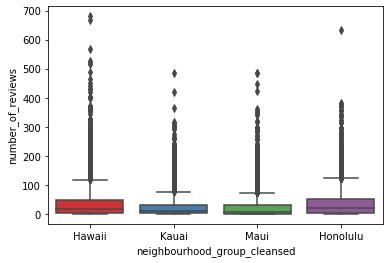

In [13]:
# Hypothesis candidates: 
# Neighborhood
#     - Is rating related to price within a neighborhood? 
#     - The highest price properties in a neighboorhood will have lower ratings than the lowest price properties?
#      - Best neighborhoods by rating
#      - Best neighborhoods by price
#      - Listing types by neighborhood
#      - Listing types by price
#      - Listing types by rating
# By island: 
#      - Is one island more expensive than the others?

import seaborn as sns
#sns.boxplot(x="day", y="total_bill", hue="smoker", data=df, palette="Set1")
sns.boxplot(
    x = "neighbourhood_group_cleansed",
    y = "number_of_reviews",
    #hue = "price",
    data = df,
    palette = "Set1"
)

# Bin by island
# data_dict[(data_dict["Group"] == "Property-related") & (data_dict["Subgroup"] == "Pricing")]

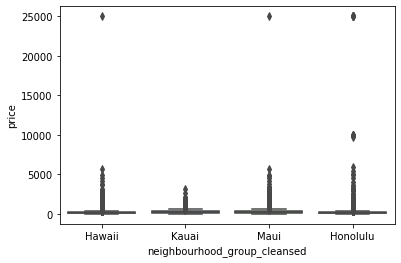

In [14]:
# Hypothesis candidates: 
# Neighborhood
#     - Is rating related to price within a neighborhood? 
#     - The highest price properties in a neighboorhood will have lower ratings than the lowest price properties?
#      - Best neighborhoods by rating
#      - Best neighborhoods by price
#      - Listing types by neighborhood
#      - Listing types by price
#      - Listing types by rating
# By island: 
#      - Is one island more expensive than the others?

import seaborn as sns
#sns.boxplot(x="day", y="total_bill", hue="smoker", data=df, palette="Set1")
sns.boxplot(
    x = "neighbourhood_group_cleansed",
    y = "price",
    data = df,
    palette = "Set1"
)

# Bin by island
# data_dict[(data_dict["Group"] == "Property-related") & (data_dict["Subgroup"] == "Pricing")]

In [15]:
data_dict[(data_dict["Group"] == "Property-related") & (data_dict["Subgroup"] == "Pricing")]

,ColumNumber,Column,Group,Subgroup,Notes
5,5,experiences_offered,Property-related,Pricing,
41,41,accommodates,Property-related,Pricing,
47,47,price,Property-related,Pricing,
48,48,weekly_price,Property-related,Pricing,
49,49,monthly_price,Property-related,Pricing,
50,50,security_deposit,Property-related,Pricing,
51,51,cleaning_fee,Property-related,Pricing,
52,52,guests_included,Property-related,Pricing,
53,53,extra_people,Property-related,Pricing,


In [16]:
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype

is_string_dtype(df['price'])
is_numeric_dtype(df['price'])
df["price"]

0         85.0
1        110.0
2         92.0
3        299.0
4         92.0
5        290.0
7        140.0
8        172.0
9         99.0
10       120.0
11       300.0
12       105.0
13       250.0
14       155.0
15       200.0
16       220.0
17       139.0
18       119.0
19        90.0
20       285.0
21        85.0
22        55.0
24       140.0
25       399.0
26       399.0
27       399.0
28        95.0
29       120.0
30       128.0
31       175.0
         ...  
23320     65.0
23322     59.0
23326    175.0
23329    199.0
23330     55.0
23331    150.0
23333    149.0
23344     80.0
23347    169.0
23357    165.0
23362    350.0
23365     80.0
23380     80.0
23402    115.0
23411    750.0
23414    155.0
23436    145.0
23445    214.0
23453    200.0
23469    120.0
23488    153.0
23499    195.0
23524    125.0
23554    175.0
23558    189.0
23569    111.0
23576     79.0
23582     70.0
23656    146.0
23741    499.0
Name: price, Length: 18291, dtype: float64

In [17]:
# Bin by island
isle = df[['latitude', 'longitude']].head(50).copy()
isle["Island"] = ""

curr_rows = len(isle)
print(f'There are {curr_rows} coordinates in the dataframe')

df["neighbourhood_group_cleansed"]

There are 50 coordinates in the dataframe


0          Hawaii
1          Hawaii
2          Hawaii
3          Hawaii
4           Kauai
5           Kauai
7           Kauai
8            Maui
9          Hawaii
10         Hawaii
11       Honolulu
12          Kauai
13       Honolulu
14         Hawaii
15           Maui
16           Maui
17         Hawaii
18           Maui
19         Hawaii
20           Maui
21         Hawaii
22         Hawaii
24         Hawaii
25          Kauai
26          Kauai
27          Kauai
28         Hawaii
29           Maui
30           Maui
31       Honolulu
           ...   
23320    Honolulu
23322      Hawaii
23326    Honolulu
23329       Kauai
23330      Hawaii
23331    Honolulu
23333        Maui
23344      Hawaii
23347    Honolulu
23357        Maui
23362       Kauai
23365       Kauai
23380      Hawaii
23402    Honolulu
23411        Maui
23414        Maui
23436    Honolulu
23445      Hawaii
23453    Honolulu
23469        Maui
23488       Kauai
23499      Hawaii
23524        Maui
23554    Honolulu
23558     

In [18]:
# If a host has a hugh number of properties then their ratings are not higher 
# than hosts with fewer properties
#Create bins
bins = [0, 50, 100, 150, 200, 250, 299]

#Create bin names 
group_names = ["0-50 properties", "51-100 properties", "101-150 properties", "151-200 properties", "201-250 properties", "251+ properties"]

#Append to data frame
df["Bin_NumProperties"] = pd.cut(df["calculated_host_listings_count"], bins, labels=group_names)

#Calculate mean review by bin
rating_mean_by_bin = df.groupby("Bin_NumProperties").mean()["review_scores_rating"]

#Display appended data frame
df.head(100)

,id,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,...,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,Bin_NumReviews,Bin_NumProperties,Bin_GroupNumber
0,5065,MAUKA BB,"Perfect for your vacation, Staycation or just ...",Mauka B & B is 400 square feet studio with a p...,"Perfect for your vacation, Staycation or just ...",none,Neighbors here are friendly but are not really...,Located near by is Kalopa State Park with 100 ...,There is a bus stop located in Honoka'a town ...,A BBQ grill is available,...,f,f,2,2,0,0,0.45,11-20,0-50 properties,1
1,5269,Upcountry Hospitality in the 'Auwai Suite,"The 'Auwai Suite is a lovely, self-contained a...","The ‘Auwai Suite is a lovely, self-contained a...","The 'Auwai Suite is a lovely, self-contained a...",none,"We are located on the ""sunny side"" of Waimea, ...",NaN,One parking spot is provided with your stay.,You'll have access to your private garden suit...,...,f,f,5,4,1,0,0.09,NaN,0-50 properties,1
2,5387,Hale Koa Studio & 1 Bedroom Units!!,This Wonderful Spacious Studio apt/flat is in ...,"Hale Koa Duplex: This duplex has a wonderful, ...",This Wonderful Spacious Studio apt/flat is in ...,none,IN a Farm belt area with small commercial farm...,tropical setting with view and easy access to ...,"Close to Major highway (belt road) accessable,...","entire apartment, with full kitchen, baths an...",...,f,f,3,3,0,0,1.36,100-200,0-50 properties,1
3,5389,Keauhou Villa,It is less than 10 minute walk to the Keauhou ...,"Location: Keauhou, Kona Coast, Big Island, Haw...",It is less than 10 minute walk to the Keauhou ...,none,It is less than 10 minute walk to the Keauhou ...,It is less than 10 minute walk to the Keauhou ...,It is less than 10 minute walk to the Keauhou ...,"Entire House with Garage, Screened Lanai, Fron...",...,f,f,3,3,0,0,0.23,1-10,0-50 properties,1
4,5390,STAY AT PRINCE KUHIO!,NaN,"Prince Kuhio, Studio Unit. Sleeps 2 privately....","Prince Kuhio, Studio Unit. Sleeps 2 privately....",none,NaN,NaN,NaN,NaN,...,f,f,1,1,0,0,1.01,100-200,0-50 properties,1
5,5434,Kauai Ocean View 3 Story Tiki Tower North Shore,"Hawaiian architecture , post and beam construc...","Our pristine and private 3 story, 3 bedroom, 2...","Hawaiian architecture , post and beam construc...",none,The resort community of Princeville has many t...,Hideaways beach is a beautiful scenic beach th...,It is best to rent a vehicle to experience the...,"We supply beach towels, beach chairs, beach um...",...,f,f,2,2,0,0,0.82,100-200,0-50 properties,1
7,5930,Poipu Beach Guest House--- Orchid,Orchid is a first floor unit with private bat...,"From your front door, walk Southeast for just ...",Orchid is a first floor unit with private bat...,none,"One of the best locations on Kauai, on a smal...",County of Kauai Permit TVR 4265,NaN,Enjoy spending time in the garden with a varie...,...,f,f,4,1,3,0,1.54,100-200,0-50 properties,1
8,7896,Beachfront Maui Sunset Condo,"GREAT VALUE ON THE BEACH! Remodeled Condo, Tas...",Sleeps up to 4 people. The Maui Sunset beachfr...,"GREAT VALUE ON THE BEACH! Remodeled Condo, Tas...",none,Conveniently located to all the sights on the ...,Beachfront resort. Free parking. Bus stop outs...,A rental car is suggested. There is local bus ...,"Swimming Pool, Sauna, Jacuzzi, shuffle board, ...",...,f,f,1,1,0,0,0.25,11-20,0-50 properties,1
9,8833,Stay in the Heart of Kona,Our condo is located right across the street f...,Stay at the ROYAL KAHILI CONDOMINIUMS with a g...,Our condo is located right across the street f...,none,"Close to the heart of downtown Kona, but far e...",W (Phone number hidden by Airbnb),The best way to get around the Big Island is t...,Access to entire space of the unit. Access to ...,...,t,t,1,1,0,0,1.90,201-250,0-50 properties,1
10,9877,Keolamaul

<function matplotlib.pyplot.show(*args, **kw)>

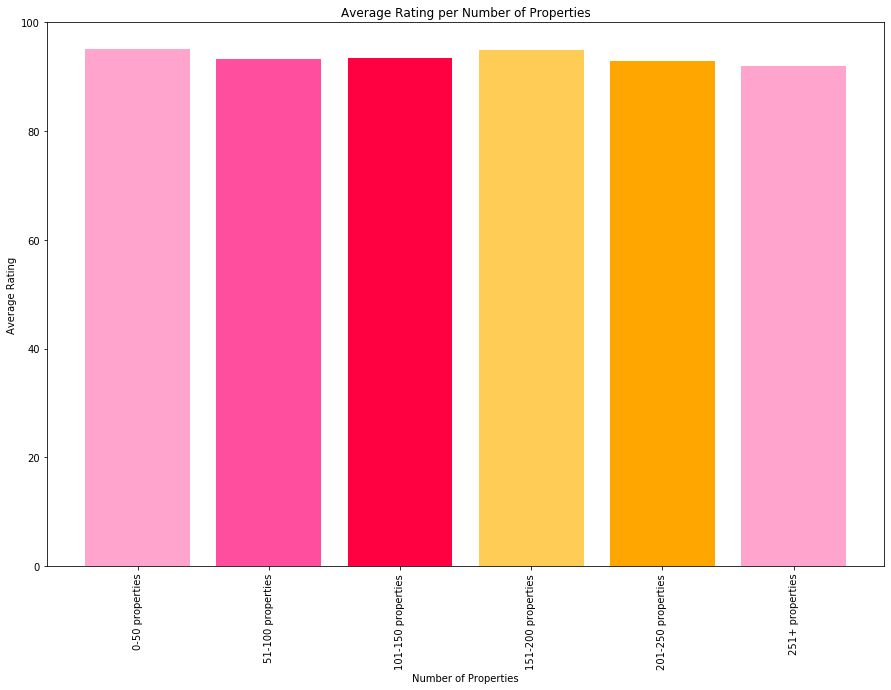

In [27]:
#Assign x and y axis values
x_axis = group_names
y_axis = rating_mean_by_bin


#Create hex color palette
hawaiian_hibiscus_hex_palette = ["#ffa4cd", "#ff4e9e", "#ff0040", "#ffcd55", "#ffa700"]

#Create bar plot of average rating by number of properties bin
plt.subplots(figsize=(15,10))
plt.title("Average Rating per Number of Properties")
plt.xlabel("Number of Properties")
plt.ylabel("Average Rating")
plt.xticks(rotation=90)
plt.ylim(0, 100)
plt.bar(x_axis, y_axis, color = hawaiian_hibiscus_hex_palette)
plt.show

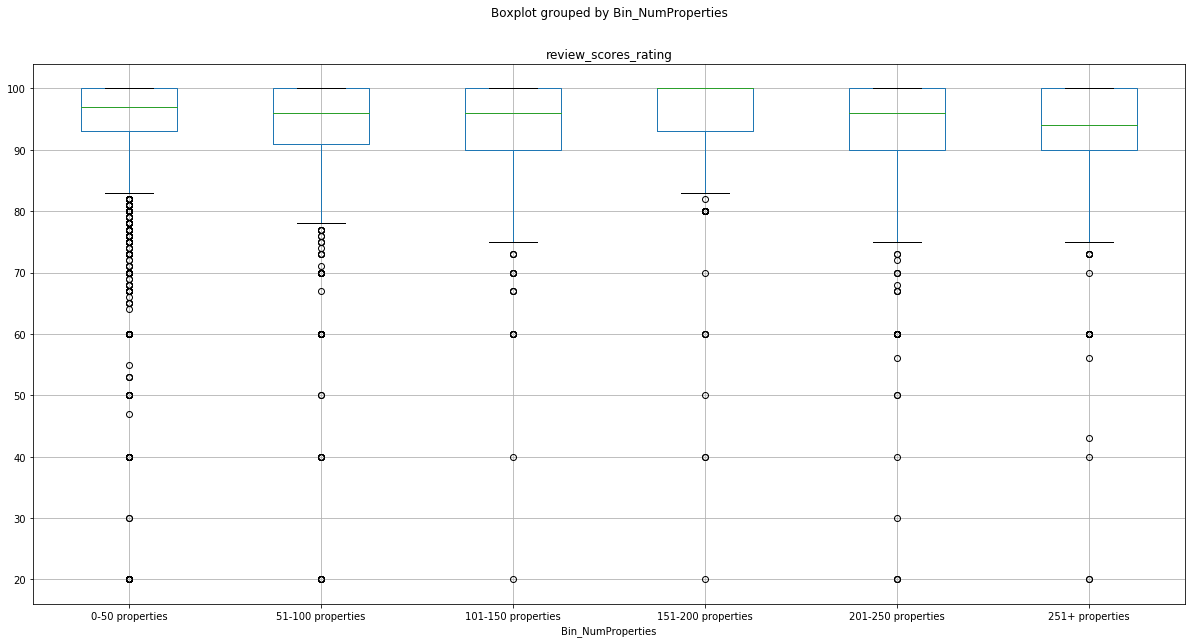

In [20]:
#Create boc plot showing rating vs number of property
df.boxplot("review_scores_rating", by="Bin_NumProperties", figsize=(20, 10))

In [63]:
# Extract individual groups
group1 = df[df["Bin_NumProperties"] == "0-50 properties"]["review_scores_rating"].dropna()
group2 = df[df["Bin_NumProperties"] == "51-100 properties"]["review_scores_rating"].dropna()
group3 = df[df["Bin_NumProperties"] == "101-150 properties"]["review_scores_rating"].dropna()
group4 = df[df["Bin_NumProperties"] == "151-200 properties"]["review_scores_rating"].dropna()
group5 = df[df["Bin_NumProperties"] == "201-250 properties"]["review_scores_rating"].dropna()
group6 = df[df["Bin_NumProperties"] == "251+ properties"]["review_scores_rating"].dropna()

#Run statistical anova
stats.f_oneway(group1, group2, group3, group4, group5, group6)

#We can accept the null hypothesis that the number of properites owned by a host has no impact on rating. 
#This means number of properties the host owns likely has no affect on the overall rating of a property.

F_onewayResult(statistic=43.20051018106537, pvalue=1.9870577727779467e-44)

<function matplotlib.pyplot.show(*args, **kw)>

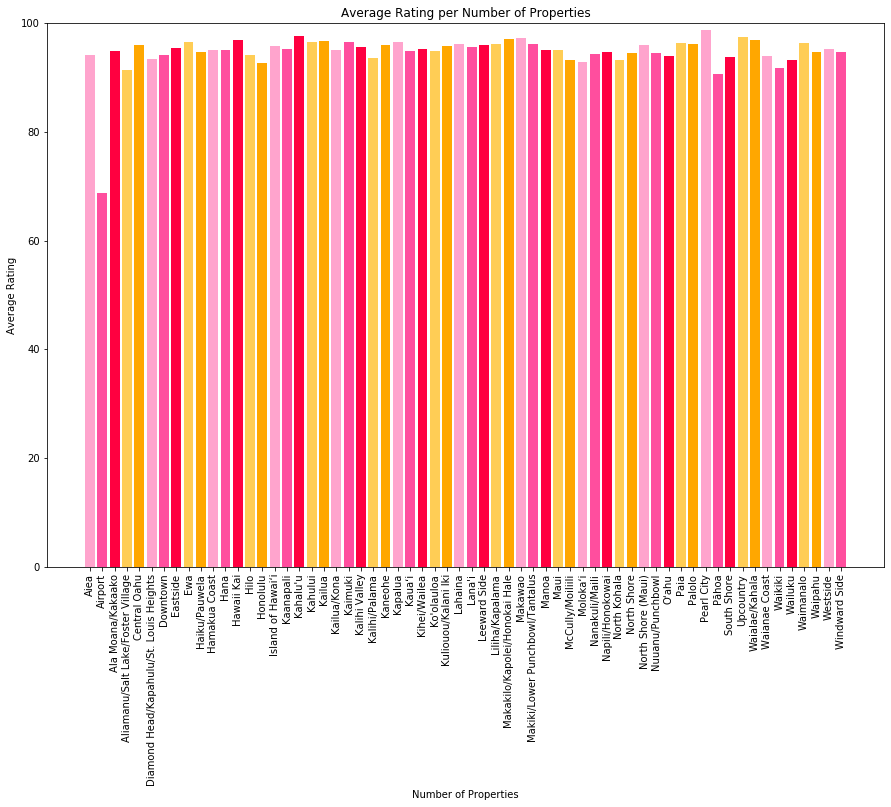

In [28]:
#Assign neighborhood list to a variable
neighborhood_list = df["neighbourhood"].unique()

#Calculate average rating per neighborhood
average_rating_per_neighborhood = df.groupby("neighbourhood").mean()["review_scores_rating"]
average_rating_per_neighborhood

#Drop nan values
cleaned_neighborhood_list = [x for x in neighborhood_list if str(x) != 'nan']
cleaned_neighborhood_list.sort()
cleaned_neighborhood_list

#Assign x and y axis values
x_axis = cleaned_neighborhood_list
y_axis = average_rating_per_neighborhood

#Create color palette
hawaiian_hibiscus_hex_palette = ["#ffa4cd", "#ff4e9e", "#ff0040", "#ffcd55", "#ffa700"]

#Create bar chart of average rating per neighborhood
plt.subplots(figsize=(15,10))
plt.xticks(rotation=90)
plt.title("Average Rating per Number of Properties")
plt.xlabel("Number of Properties")
plt.ylabel("Average Rating")
plt.ylim(0, 100)
plt.bar(x_axis, y_axis, color = hawaiian_hibiscus_hex_palette, align='center')
plt.show

The r-squared is: 0.018787686050668887


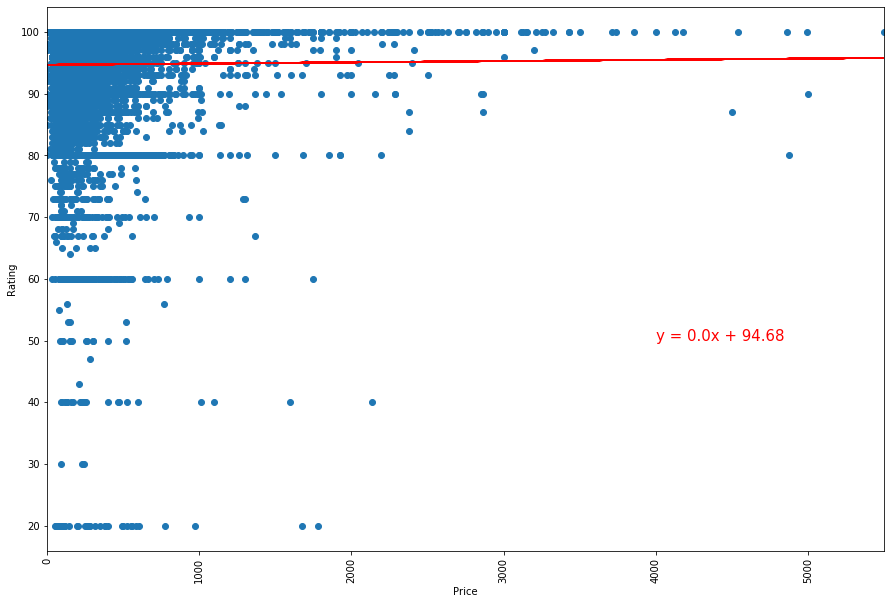

In [62]:
#Assign x and y axis values
x_axis = df["price"]
y_axis = df["review_scores_rating"]

#Drop nan values with mask
mask = ~np.isnan(x_axis) & ~np.isnan(y_axis)

#Calculate r squared and linear regression
slope, intercept, r_value, p_value, std_err = stats.linregress(x_axis[mask], y_axis[mask])
regress_values = x_axis * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

#Create scatterplot
plt.subplots(figsize=(15,10))
plt.xticks(rotation=90)
plt.xlim(0, 5500)
plt.plot(x_axis,regress_values,"r-")
plt.scatter(x_axis,y_axis)
plt.annotate(line_eq,(4000,50),fontsize=15,color="red")
plt.xlabel('Price')
plt.ylabel('Rating')
print(f"The r-squared is: {r_value}")
plt.show()

#We can accept the null hypothesis that price has no impact on rating. 
#This means price likely has no affect on the overall rating of a property.